## In this assignment students need to predict whether a person makes over 50K per year or not from classic adult dataset using XGBoost.

### loading libraries

In [120]:
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from sklearn import metrics, tree
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

### loading dataset

In [11]:
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)

In [210]:
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, header = None)

In [5]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
test_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


## Data cleaning and one hot encoding

In [211]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
'occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
'native_country', 'wage_class']

In [14]:
train_set.columns = col_labels

In [212]:
test_set.columns = col_labels

In [11]:
train_set.head(2)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [12]:
test_set.head(2)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.


In [20]:
train_set.describe(include='all')

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [21]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [22]:
train_set.dtypes[train_set.dtypes=='object']

workclass         object
education         object
marital_status    object
occupation        object
relationship      object
race              object
sex               object
native_country    object
wage_class        object
dtype: object

In [23]:
train_set.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

In [25]:
train_set['wage_class'] = train_set.wage_class.map({' >50K' : 1, ' <=50K' : 0})

In [27]:
train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [30]:
train_set.isna().sum(axis=0)

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

In [32]:
test_set.isna().sum(axis=0)

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

In [44]:
train_set.workclass[train_set.workclass == ' ?'].shape

(1836,)

In [46]:
train_set.workclass.unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [47]:
train_set.education.unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
       ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'], dtype=object)

In [48]:
train_set.marital_status.unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [49]:
train_set.occupation.unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [50]:
train_set.relationship.unique()

array([' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative'], dtype=object)

In [51]:
train_set.race.unique()

array([' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other'], dtype=object)

In [52]:
train_set.sex.unique()

array([' Male', ' Female'], dtype=object)

In [53]:
train_set.native_country.unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary', ' Holand-Netherlands'], dtype=object)

In [54]:
train_set.corr()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,wage_class
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.234037
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768,-0.009463
education_num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123,0.335154
capital_gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409,0.223329
capital_loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256,0.150526
hours_per_week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000,0.229689
wage_class,0.234037,-0.009463,0.335154,0.223329,0.150526,0.229689,1.000000


In [55]:
train_set.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'wage_class'],
      dtype='object')

In [82]:
# create dataframes with an intercept column and dummy variables
y, X = dmatrices('wage_class ~ age+fnlwgt+education_num+capital_gain+capital_loss+hours_per_week+C(education)+C(occupation)+\
                 C(workclass)', train_set, return_type="dataframe")

In [62]:
y.head()

,wage_class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [63]:
X.head()

,Intercept,C(education)[T. 11th],C(education)[T. 12th],C(education)[T. 1st-4th],C(education)[T. 5th-6th],C(education)[T. 7th-8th],C(education)[T. 9th],C(education)[T. Assoc-acdm],C(education)[T. Assoc-voc],C(education)[T. Bachelors],...,C(workclass)[T. Self-emp-inc],C(workclass)[T. Self-emp-not-inc],C(workclass)[T. State-gov],C(workclass)[T. Without-pay],age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,39.0,77516.0,13.0,2174.0,0.0,40.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,50.0,83311.0,13.0,0.0,0.0,13.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,38.0,215646.0,9.0,0.0,0.0,40.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,53.0,234721.0,7.0,0.0,0.0,40.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,28.0,338409.0,13.0,0.0,0.0,40.0


Text(0, 0.5, 'Frequency')

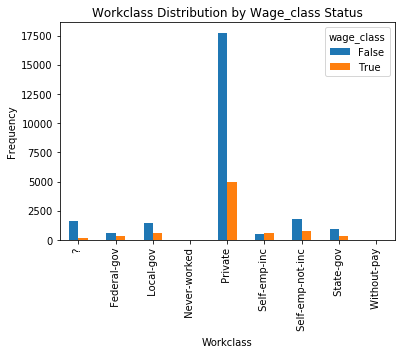

In [64]:
# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(train_set.workclass, train_set.wage_class.astype(bool)).plot(kind='bar')
plt.title('Workclass Distribution by Wage_class Status')
plt.xlabel('Workclass')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

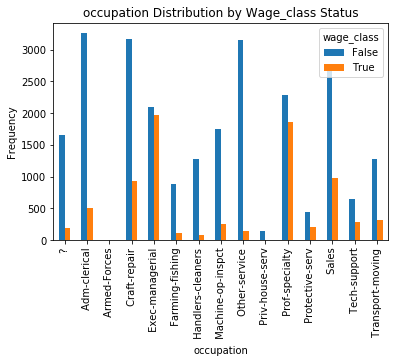

In [65]:
# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(train_set.occupation, train_set.wage_class.astype(bool)).plot(kind='bar')
plt.title('occupation Distribution by Wage_class Status')
plt.xlabel('occupation')
plt.ylabel('Frequency')

Text(0, 0.5, 'frequency')

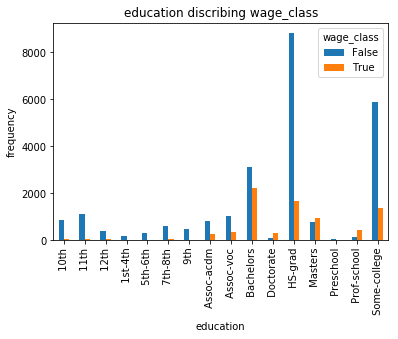

In [71]:
pd.crosstab(train_set.education, train_set.wage_class.astype(bool)).plot(kind='bar')
plt.title('education discribing wage_class')
plt.xlabel('education')
plt.ylabel('frequency')

## Model fitting

In [121]:
## Ensemble RandomForest....
from sklearn.ensemble import RandomForestClassifier

In [112]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [113]:
rfc.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [114]:
rfc.score(X,y)

0.9998464420625902

In [122]:
for name, score in zip(X.columns, rfc.feature_importances_):
    print(name, score)

Intercept 0.0
C(education)[T. 11th] 0.001589675089982119
C(education)[T. 12th] 0.0006799051439680416
C(education)[T. 1st-4th] 0.00021193322362839375
C(education)[T. 5th-6th] 0.0006097255295290318
C(education)[T. 7th-8th] 0.0012616626445153523
C(education)[T. 9th] 0.0008447464499741676
C(education)[T. Assoc-acdm] 0.002189636358404935
C(education)[T. Assoc-voc] 0.0026472370803949
C(education)[T. Bachelors] 0.010650914132924672
C(education)[T. Doctorate] 0.003814815561291991
C(education)[T. HS-grad] 0.005877141607759689
C(education)[T. Masters] 0.008023523018513688
C(education)[T. Preschool] 5.863941256381782e-05
C(education)[T. Prof-school] 0.0052494479996100345
C(education)[T. Some-college] 0.004405703216424944
C(occupation)[T. Adm-clerical] 0.006474234679115676
C(occupation)[T. Armed-Forces] 2.567612787940304e-05
C(occupation)[T. Craft-repair] 0.006082750500269542
C(occupation)[T. Exec-managerial] 0.020651525819429417
C(occupation)[T. Farming-fishing] 0.0032959741101032075
C(occupation

### #As feature importance show only 4 columns shows most higher importance percentange

In [126]:
#age = 22%
#fnlwgt = 26%
#capital_gain = 12%
#hours_per_week = 10%

### Implementation using Decision tree

In [148]:
dt = tree.DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=50)
dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [149]:
dt.score(X,y)

0.9998464420625902

In [154]:
for name, score in zip(X.columns, dt.feature_importances_):
    print(name, score)

Intercept 0.0
C(education)[T. 11th] 0.0005848479430388316
C(education)[T. 12th] 0.00026094482664787926
C(education)[T. 1st-4th] 0.0
C(education)[T. 5th-6th] 0.00043306902836816487
C(education)[T. 7th-8th] 0.0005706229669088003
C(education)[T. 9th] 0.0008950236618419772
C(education)[T. Assoc-acdm] 0.001261465314554089
C(education)[T. Assoc-voc] 0.003271426931163499
C(education)[T. Bachelors] 0.0024864318100468867
C(education)[T. Doctorate] 0.0008652394920682954
C(education)[T. HS-grad] 0.001976059400105387
C(education)[T. Masters] 0.003456326813899245
C(education)[T. Preschool] 0.0001643405695479165
C(education)[T. Prof-school] 0.0005433228990398296
C(education)[T. Some-college] 0.004813843653964294
C(occupation)[T. Adm-clerical] 0.008197944878560721
C(occupation)[T. Armed-Forces] 0.0
C(occupation)[T. Craft-repair] 0.007865780218784665
C(occupation)[T. Exec-managerial] 0.011343101843458958
C(occupation)[T. Farming-fishing] 0.0035797942482283804
C(occupation)[T. Handlers-cleaners] 0.0032

## Implementation using Xgboost

In [160]:
X_xg = X
y_xg = y

In [168]:
# Renaming columns to fit in xgb algorithm
X_xg.columns = ['Intercept', 'education_11th', 'education_12th',
                'education_1st_4th', 'education_5th_6th',
                'education_7th_8th', 'education_9th',
                'education_Assoc_acdm', 'education_Assoc_voc',
                'education_Bachelors', 'education_Doctorate',
                'education_HS_grad', 'education_Masters',
                'education_Preschool', 'education_Prof_school',
                'education_Some_college', 'occupation_Adm_clerical',
                'occupation_Armed_Forces', 'occupation_Craft_repair',
                'occupation_Exec_managerial',
                'occupation_Farming_fishing',
                'occupation_Handlers_cleaners',
                'occupation_Machine_op_inspct',
                'occupation_Other_service', 'occupation_Priv_house_serv',
                'occupation_Prof_specialty', 'occupation_Protective_serv',
                'occupation_Sales', 'occupation_Tech_support',
                'occupation_Transport_moving', 'workclass_Federal_gov',
                'workclass_Local_gov', 'workclass_Never_worked',
                'workclass_Private', 'workclass_Self_emp_inc',
                'workclass_Self_emp_not_inc', 'workclass_State_gov',
                'workclass_Without_pay', 'age', 'fnlwgt', 'education_num',
                'capital_gain', 'capital_loss', 'hours_per_week']

In [177]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 50,
    'learning_rate': 1, #1.0
    'silent': 1, #1.0
    'n_estimators': 120
}

In [178]:
xgb = XGBClassifier(**params).fit(X_xg, y_xg)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [179]:
xgb.score(X_xg, y_xg)

0.9998464420625902

### Problem 2:
### Which factors are important

In [186]:
pd.DataFrame({'columns': X_xg.columns, 'gain': xgb.feature_importances_}).sort_values(by='gain', ascending=False).head()

,columns,gain
41,capital_gain,0.263435
42,capital_loss,0.094936
23,occupation_Other_service,0.069128
40,education_num,0.039422
24,occupation_Priv_house_serv,0.031475


## Evalution of model using train data

In [103]:
from sklearn.metrics import accuracy_score

In [188]:
#RandomForest prediction on train data
y_pred = rfc.predict(X)

In [110]:
y_pred

array([0., 0., 0., ..., 0., 0., 1.])

In [116]:
accuracy_score(y, y_pred)

0.9998464420625902

In [189]:
#Decision tree classifier

In [190]:
y_pred_dt = dt.predict(X)
y_pred_dt

array([0., 0., 0., ..., 0., 0., 1.])

In [192]:
accuracy_score(y, y_pred_dt)

0.9998464420625902

In [ ]:
#Xgboost classifier

In [196]:
y_pred_xg = xgb.predict(X_xg)
y_pred_xg

array([0., 0., 0., ..., 0., 0., 1.])

In [197]:
accuracy_score(y_pred_xg, y_xg)

0.9998464420625902

## Model evalution using test data

In [215]:
test_set['wage_class'] = test_set.wage_class.map({' >50K.' : 1, ' <=50K.' : 0})

In [214]:
test_set.wage_class.unique()

array([' <=50K.', ' >50K.'], dtype=object)

In [216]:
test_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0


In [217]:
# create dataframes with an intercept column and dummy variables
y_test, X_test = dmatrices('wage_class ~ age+fnlwgt+education_num+capital_gain+capital_loss+hours_per_week+C(education)+C(occupation)+\
                 C(workclass)', test_set, return_type="dataframe")

In [218]:
y_test.head()

,wage_class
0,0.0
1,0.0
2,1.0
3,1.0
4,0.0


In [219]:
# Renaming columns to fit in xgb algorithm
X_test.columns = ['Intercept', 'education_11th', 'education_12th',
                'education_1st_4th', 'education_5th_6th',
                'education_7th_8th', 'education_9th',
                'education_Assoc_acdm', 'education_Assoc_voc',
                'education_Bachelors', 'education_Doctorate',
                'education_HS_grad', 'education_Masters',
                'education_Preschool', 'education_Prof_school',
                'education_Some_college', 'occupation_Adm_clerical',
                'occupation_Armed_Forces', 'occupation_Craft_repair',
                'occupation_Exec_managerial',
                'occupation_Farming_fishing',
                'occupation_Handlers_cleaners',
                'occupation_Machine_op_inspct',
                'occupation_Other_service', 'occupation_Priv_house_serv',
                'occupation_Prof_specialty', 'occupation_Protective_serv',
                'occupation_Sales', 'occupation_Tech_support',
                'occupation_Transport_moving', 'workclass_Federal_gov',
                'workclass_Local_gov', 'workclass_Never_worked',
                'workclass_Private', 'workclass_Self_emp_inc',
                'workclass_Self_emp_not_inc', 'workclass_State_gov',
                'workclass_Without_pay', 'age', 'fnlwgt', 'education_num',
                'capital_gain', 'capital_loss', 'hours_per_week']

### Problem 1:
### Prediction task is to determine whether a person makes over 50K a year.

In [ ]:
#RandomForest classifier

In [222]:
y_pred_test_rf = rfc.predict(X_test)

In [223]:
accuracy_score(y_test, y_pred_test_rf)

0.8163503470302806

In [ ]:
#Decision tree

In [224]:
y_pred_test_dc = dt.predict(X_test)

In [225]:
accuracy_score(y_test, y_pred_test_dc)

0.7751980836557951

In [ ]:
#Xgb algo

In [226]:
y_pred_test_xg = xgb.predict(X_test)

In [227]:
accuracy_score(y_test, y_pred_test_xg)

0.8207112585222038

### Model performance comparison using training data

In [193]:
cross_val_score(rfc, X, y, cv=5, scoring='accuracy')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y wa

array([0.81774912, 0.81879607, 0.82324939, 0.8240172 , 0.82862408])

In [152]:
cross_val_score(dt, X, y, cv=5, scoring='accuracy')

array([0.77537233, 0.77979115, 0.77579853, 0.78055897, 0.77856265])

In [180]:
cross_val_score(xgb, X_xg, y_xg, cv=5, scoring='accuracy')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.81559957, 0.82263514, 0.81925676, 0.82232801, 0.82017813])

### Problem 3:
### Which algorithms are best for this dataset

## Model performance comparision using test data

In [228]:
cross_val_score(rfc, X_test, y_test, cv=5, scoring='accuracy')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y wa

array([0.81516733, 0.82985258, 0.8240172 , 0.82463145, 0.81265356])

In [229]:
cross_val_score(dt, X_test, y_test, cv=5, scoring='accuracy')

array([0.77678846, 0.7730344 , 0.77211302, 0.78194103, 0.78163391])

In [230]:
cross_val_score(xgb, X_test, y_test, cv=5, scoring='accuracy')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.82345717, 0.82309582, 0.81081081, 0.82371007, 0.80712531])